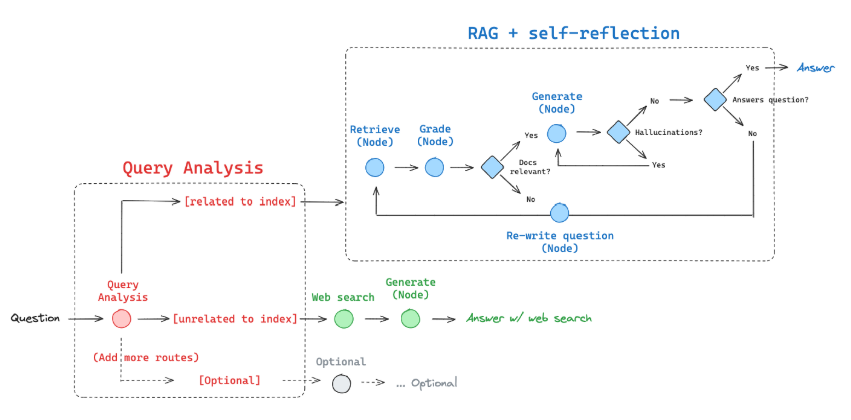

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_upstage import UpstageEmbeddings
from langchain_chroma import Chroma

embeddings = UpstageEmbeddings(model="solar-embedding-1-large")

vector_store = Chroma(collection_name="income_tax_collection",
                      embedding_function=embeddings,
                      persist_directory="./income_tax_collection")

retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from langchain_upstage import ChatUpstage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)
llm = ChatUpstage()

In [4]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['vector_store', 'llm', 'web_search'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to one of the following targets: 'vector_store', 'llm', or 'web_search'.

- Use 'vector_store' **only if the question is clearly about Korean income tax or income tax law (up to December 2024)**.
- Use 'llm' if the question can be answered with general knowledge, is short, or requires reasoning but does **not** need external information or up-to-date data.
- Use 'web_search' **only if the question requires current or real-time information, such as recent news, statistics, or updates after 2024**.
"""

router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

structured_llm = llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['vector_store', 'llm', 'web_search']:
    query = state['query']
    
    router_chain = router_prompt | structured_llm 
        
    route = router_chain.invoke({'query': query})
    
    print(f"router: {route.target}")

    return route.target

In [5]:
from langchain_tavily import TavilySearch

tavily_search_tool = TavilySearch(      
    max_results=3,
    topic="general",
)

def web_search(state: AgentState) -> AgentState:
    query = state['query']
    results = tavily_search_tool.invoke(query)
    print(f"web_search: {results}")
    return {'context': results}

In [6]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

generate_prompt = hub.pull("rlm/rag-prompt")

def web_generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm | StrOutputParser()
    response = rag_chain.invoke({'question': query, 'context': context})
    print(f"web_generate: {response}")
    return {'answer': response}

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

def basic_generate(state: AgentState) -> AgentState:
    query = state['query']
    basic_llm_chain = llm | StrOutputParser()
    response = basic_llm_chain.invoke(query)
    print(f"basic_generate: {response}")
    return {'answer': response}

In [8]:
from self_rag_graph import graph as income_tax_self_rag_subgraph

graph_builder.add_node('income_tax_agent', income_tax_self_rag_subgraph)
graph_builder.add_node('web_search', web_search)
graph_builder.add_node('web_generate', web_generate)
graph_builder.add_node('basic_generate', basic_generate)

c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(
c:\Users\hyunseo\Desktop\learn_langgraph\.venv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [9]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START, 
    router,
    {
        'vector_store': 'income_tax_agent',
        'llm': 'basic_generate',
        'web_search': 'web_search'
    }
)

graph_builder.add_edge('web_search', 'web_generate')
graph_builder.add_edge('web_generate', END)
graph_builder.add_edge('basic_generate', END)
graph_builder.add_edge('income_tax_agent', END)

In [10]:
graph = graph_builder.compile()

In [11]:
# from IPython.display import Image, display

# display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# initial_state = {'query': '대한민국의 수도는 어디인가요?'}
# graph.invoke(initial_state)

: 

In [ ]:
initial_state = {'query': '연봉 5천만원인 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

router: vector_store
retrieve: [Document(id='05aa221c-2aa8-46bf-979c-70bc52d7a521', metadata={'source': './documents/income_tax.txt'}, page_content='130만원 이하   \n산출세액의 10분의 55 \n130만원 초과   \n71천원과 (130만원을 초과하는 금액의 10분의 30)  \n\n② 제1항에 대하여 공제받는 다음 각 호의 계산에 따른 금액을 초과하는 경우에 초과하는 금액은 없는 것으로 한다. <신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천만원 이하인 경우: 74천원 = (총급여액 - 300만원) × 8/1000. 단, 위 금액은 적은 경우 6천원으로 한다.\n2. 총급여액이 3천만원 초과 7천만원 이하인 경우: 66천원 = (총급여액 - 7천만원) × 1/2. 단, 위 금액이 50만원보다 적은 경우에는 50만원으로 한다.\n3. 총급여액이 1억원 미만일 경우에는 경우: 50만원 = (총급여액 - 1억원) × 1/2. 단, 위 금액이 20만원보다 적은 경우에는 20만원으로 한다.\n4. 일금공로자의 근로소득에 대해 제134조제3항에 대한 원천징수를 하는 경우에는 해도 근로소득에 대한 산출세액의 100세 50에 해당하는 금액은 그 산출세액에 적용된다. <개정 2014. 1. 1.>\n[전문개정 2021. 1.]  \n제59조2의2(자산세예고제)\n① 종합소득에 있는 거주자이기 근로제대상자에 해당하는 자녀(입장 및 위탁아동을 포함하며, 이하 이 조에서 "공제대상자"라 한다) 및 소득세법 제57조 이상의 사례에 대해서는 다음 각 호의 구분에 따른 금액을 종합소득세법에 공제받는다. <개정 2015. 5. 13., 2017. 12. 31., 2018. 12. 19., 2019. 12. 31., 2022. 12. 31., 2023. 12. 31.>  \n\n1명인 경우: 연 15만원\n2명인

In [ ]:
initial_state = {'query': '역삼 맛집을 추천해주세요'}
graph.invoke(initial_state)

router: web_search
web_search: {'query': '역삼 맛집을 추천해주세요', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '역삼역 맛집 베스트10 추천 2024 플레이스 맛집', 'url': 'https://jdblue2022.tistory.com/entry/역삼역-맛집-베스트10', 'content': '역삼역 맛집 베스트10 추천 2024 플레이스 맛집 역삼역 맛집 베스트10 추천 2024 플레이스 맛집 오늘은 강남의 중심인 역삼역 근처의 맛집 베스트 10곳을 소개해드리고자 하는데\xa0양대 포털의\xa0플레이스를 중심으로 순위를 취합하여 역삼역 로컬 맛집들과 함께 여러 음식점을\xa0묶어서 역삼\xa0맛집을 정리해드리고자 합니다. 역삼역 맛집 베스트10 음식점 주요 메뉴 역삼역 맛집 베스트 10 정리 역삼역 이도곰탕 플레이스(구글 평점 4.2) 역삼역 대우부대찌개 플레이스(구글 평점 4.2) 역삼역 호보식당 플레이스(구글 평점 4.4) 역삼역 옛날농장 플레이스(구글 평점 4.0) 역삼역 고갯마루 플레이스(구글 평점 4.2) 역삼역 보슬보슬 플레이스(구글 평점 4.1) 역삼역 고향마을 플레이스(구글 평점 4.2) 역삼역 서울집 플레이스(구글 평점 4.2) 이렇게 오늘은 역삼역 근처의 소문난 맛집 10곳을 네이버와 구글 양대 포털의 플레이스 순위를 기준으로 소개해드렸는데요. 역삼역 맛집 베스트10 썸네일', 'score': 0.8342047, 'raw_content': None}, {'title': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플', 'url': 'https://forourtour.com/역삼동-맛집/', 'content': '관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강남역 센터필드 데이트 놀거리 지도 음식점 분위기 재방문 리뷰 리스트 입니다. 

{'query': '역삼 맛집을 추천해주세요',
 'context': {'query': '역삼 맛집을 추천해주세요',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'title': '역삼역 맛집 베스트10 추천 2024 플레이스 맛집',
    'url': 'https://jdblue2022.tistory.com/entry/역삼역-맛집-베스트10',
    'content': '역삼역 맛집 베스트10 추천 2024 플레이스 맛집 역삼역 맛집 베스트10 추천 2024 플레이스 맛집 오늘은 강남의 중심인 역삼역 근처의 맛집 베스트 10곳을 소개해드리고자 하는데\xa0양대 포털의\xa0플레이스를 중심으로 순위를 취합하여 역삼역 로컬 맛집들과 함께 여러 음식점을\xa0묶어서 역삼\xa0맛집을 정리해드리고자 합니다. 역삼역 맛집 베스트10 음식점 주요 메뉴 역삼역 맛집 베스트 10 정리 역삼역 이도곰탕 플레이스(구글 평점 4.2) 역삼역 대우부대찌개 플레이스(구글 평점 4.2) 역삼역 호보식당 플레이스(구글 평점 4.4) 역삼역 옛날농장 플레이스(구글 평점 4.0) 역삼역 고갯마루 플레이스(구글 평점 4.2) 역삼역 보슬보슬 플레이스(구글 평점 4.1) 역삼역 고향마을 플레이스(구글 평점 4.2) 역삼역 서울집 플레이스(구글 평점 4.2) 이렇게 오늘은 역삼역 근처의 소문난 맛집 10곳을 네이버와 구글 양대 포털의 플레이스 순위를 기준으로 소개해드렸는데요. 역삼역 맛집 베스트10 썸네일',
    'score': 0.8342047,
    'raw_content': None},
   {'title': '역삼동 맛집 추천 베스트 10 | 역삼역 강남역 데이트 | 점심 저녁 핫플',
    'url': 'https://forourtour.com/역삼동-맛집/',
    'content': '관련 검색어에는 서울 역삼동 맛집 추천 베스트 한식 일식 술집 점심 저녁 핫플 역삼역 강